In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
#Normalize the images to be in the range [0 - 1] {rescaling}.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [3]:
#Reshape the images to be 28 × 28 × 1
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [4]:
# Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5

x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [5]:
# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)

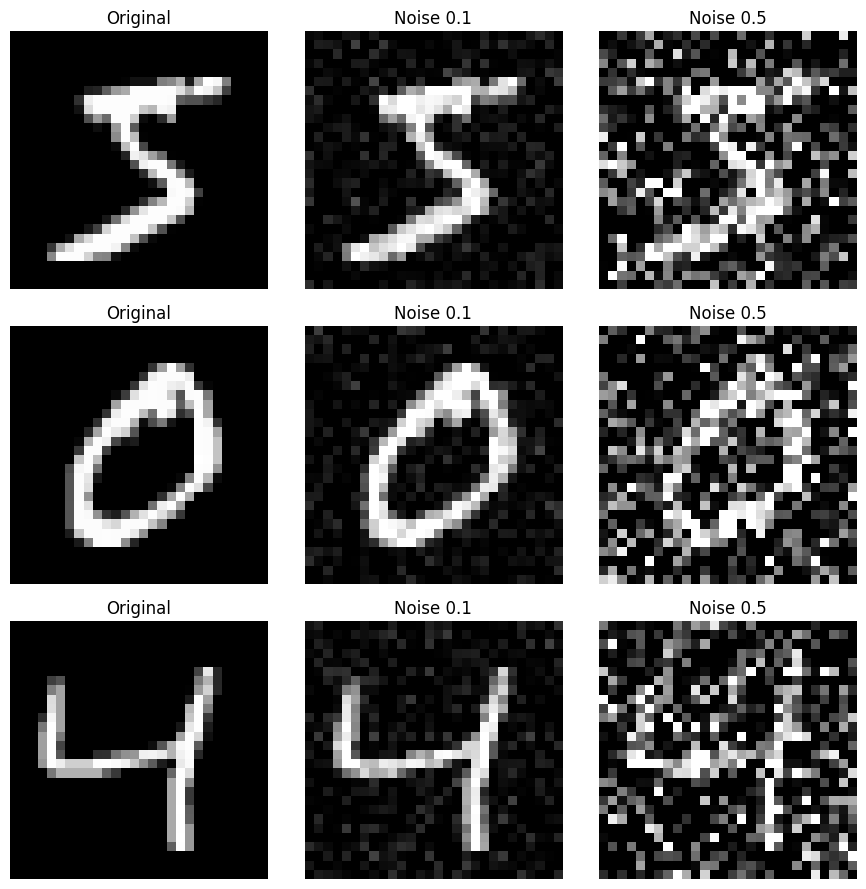

In [6]:
# Visualize in a 3 x 3 grid
n = 3  # number of images to show
plt.figure(figsize=(9, 9))
for i in range(n):
    # Original image
    ax = plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Low noise image
    ax = plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
    plt.title("Noise 0.1")
    plt.axis('off')

    # High noise image
    ax = plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
    plt.title("Noise 0.5")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D

def build_encoder(input_shape=(28, 28, 1)):
    """
    Builds the encoder part of the convolutional autoencoder.

    Parameters:
        input_shape (tuple): Shape of the input image. Default is (28, 28, 1) for MNIST.

    Returns:
        input_img (Keras Input): Input layer of the model.
        encoded (Keras Tensor): Encoded representation after convolution and pooling.
    """
    input_img = Input(shape=input_shape, name="input")
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)
    return input_img, encoded

In [8]:
from tensorflow.keras.layers import Conv2D, UpSampling2D

def build_decoder(encoded_input):
    """
    Builds the decoder part of the convolutional autoencoder.

    Parameters:
        encoded_input (Keras Tensor): The output from the encoder.

    Returns:
        decoded (Keras Tensor): The reconstructed output after upsampling and convolution.
    """
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
    return decoded

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_autoencoder():
    """
    Constructs and compiles the full convolutional autoencoder by connecting encoder and decoder.

    Returns:
        autoencoder (Keras Model): Compiled autoencoder model.
    """
    input_img, encoded_output = build_encoder()
    decoded_output = build_decoder(encoded_output)
    autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder

In [10]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoded (MaxPooling2D)               │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoded (Conv2D)                     │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Build the autoencoder from previous steps
autoencoder = build_autoencoder()
# Train with noisy input and clean target
history = autoencoder.fit(
    x_train_noisy_high, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy_high, x_test)
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.2514 - val_loss: 0.1124
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1105 - val_loss: 0.1043
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1043 - val_loss: 0.1012
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1013 - val_loss: 0.0993
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1000 - val_loss: 0.0982
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0987 - val_loss: 0.0975
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0978 - val_loss: 0.0971
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0970 - val_loss: 0.0960
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0965 - val_loss: 0.0959
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0961 - val_loss: 0.0956


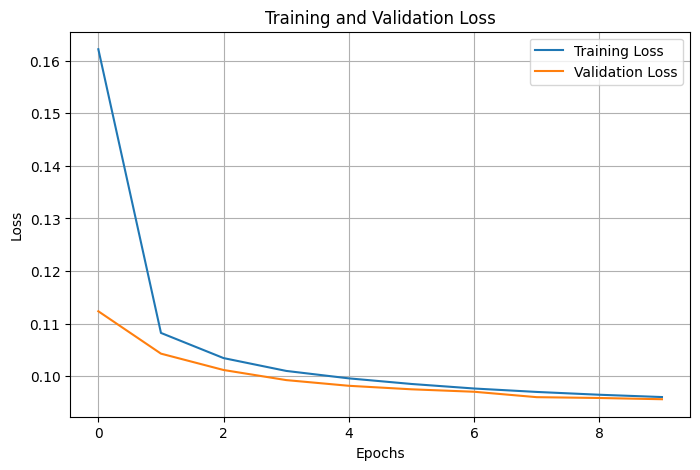

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


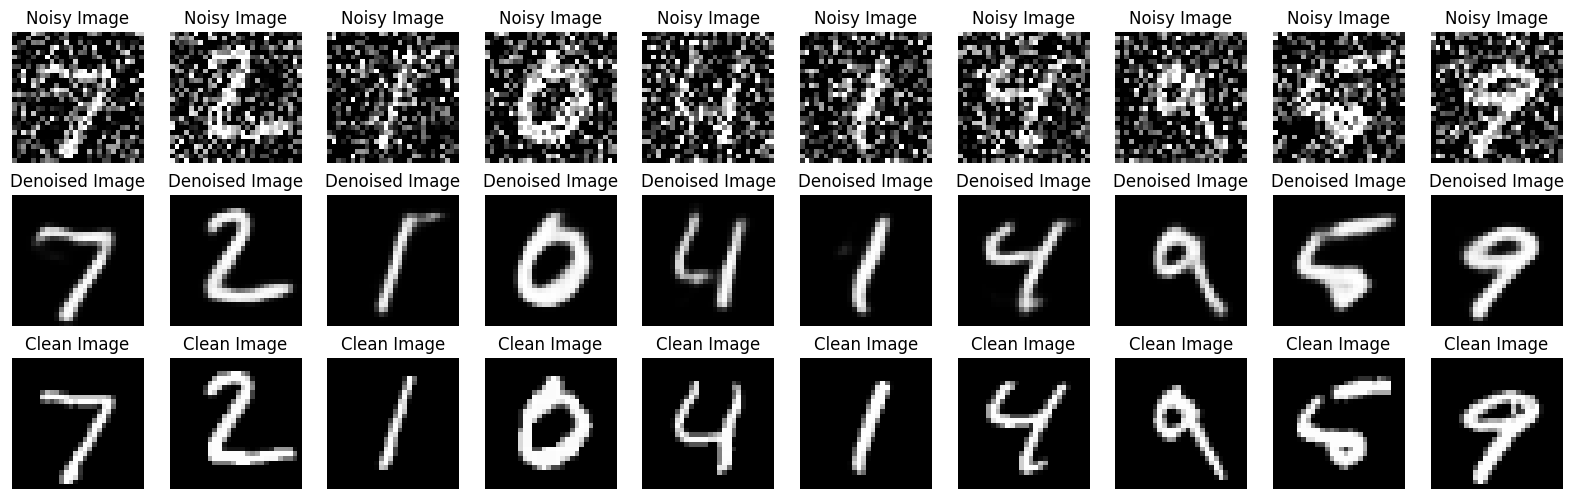

In [17]:
# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy_high)
# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Plot noisy images
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy Image")
        plt.axis('off')
        # Plot denoised images
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised Image")
        plt.axis('off')
        # Plot clean images
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
        plt.title("Clean Image")
        plt.axis('off')
    plt.show()
# Display the first 10 images
plot_images(x_test_noisy_high, denoised_images, x_test, n=10)

In [13]:
!unzip /content/drive/MyDrive/AI/Copy-of-devnagari-digit.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/DevanagariHandwrittenDigitDataset/Train/digit_7/10299.png  
  inflating: /content/DevanagariHandwrittenDigitDataset/Train/digit_7/10300.png  
  inflating: /content/DevanagariHandwrittenDigitDataset/Train/digit_7/10301.png  
  inflating: /content/DevanagariHandwrittenDigitDataset/Train/digit_7/10302.png  
  inflating: /content/DevanagariHandwrittenDigitDataset/Train/digit_7/10303.png  
  inflating: /content/DevanagariHandwrittenDigitDataset/Train/digit_7/10304.png  
  inflating: /content/DevanagariHandwrittenDigitDataset/Train/digit_7/10306.png  
  inflating: /content/DevanagariHandwrittenDigitDataset/Train/digit_7/10307.png  
  inflating: /content/DevanagariHandwrittenDigitDataset/Train/digit_7/104017.png  
  inflating: /content/DevanagariHandwrittenDigitDataset/Train/digit_7/104018.png  
  inflating: /content/DevanagariHandwrittenDigitDataset/Train/digit_7/104019.png  
  inflating: /content/DevanagariHandwrittenD

In [48]:
import os
import numpy as np
from PIL import Image

# Path to your Devanagari dataset
train_dir = "/content/DevanagariHandwrittenDigitDataset/Train"
test_dir = "/content/DevanagariHandwrittenDigitDataset/Test"

# Define image size
img_height, img_width = 28, 28

# Function to load images from the folder
def load_devanagari_images(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))  # Sorted class names (digit_0, digit_1, ...)
    class_map = {name: i for i, name in enumerate(class_names)}  # Map class names to labels

    for class_name in class_names:
        class_path = os.path.join(folder, class_name)
        label = class_map[class_name]

        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            # Load image using PIL
            img = Image.open(img_path).convert("L")  # Convert to grayscale
            img = img.resize((img_width, img_height))  # Resize to (28,28)
            img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load training and testing datasets
x_train, y_train = load_devanagari_images(train_dir)
x_test, y_test = load_devanagari_images(test_dir)

# Shuffle the datasets
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_test, y_test = shuffle(x_test, y_test, random_state=42)

# Reshape images for Keras compatibility (add channel dimension)
x_train = x_train.reshape(-1, img_height, img_width, 1)
x_test = x_test.reshape(-1, img_height, img_width, 1)

# One-hot encode the labels (Devanagari digits 0-9)
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Print dataset shape
print(f"Training set: {x_train.shape}, Labels: {y_train.shape}")
print(f"Testing set: {x_test.shape}, Labels: {y_test.shape}")


Training set: (17000, 28, 28, 1), Labels: (17000, 10)
Testing set: (3000, 28, 28, 1), Labels: (3000, 10)


In [54]:
def add_gaussian_noise(images, noise_factor=0.2):
    noisy_images = images + noise_factor * np.random.randn(*images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images
# Adding noise to the training and test images
x_train_noisy = add_gaussian_noise(x_train)
x_test_noisy = add_gaussian_noise(x_test)

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

input_shape = (28, 28, 1)
def build_autoencoder():
    input_img = Input(shape=input_shape)
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 14x14
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)  # 7x7
    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)  # 14x14
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # 28x28
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    # Model
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_16 (UpSampling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_17 (UpSampling2D)      │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
)

Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.3624 - val_loss: 0.1723
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1690 - val_loss: 0.1633
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1618 - val_loss: 0.1589
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1587 - val_loss: 0.1570
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1569 - val_loss: 0.1557
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1552 - val_loss: 0.1551
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1549 - val_loss: 0.1535
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1537 - val_loss: 0.1541
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1527 - val_loss: 0.1521
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1525 - val_loss: 0.1517


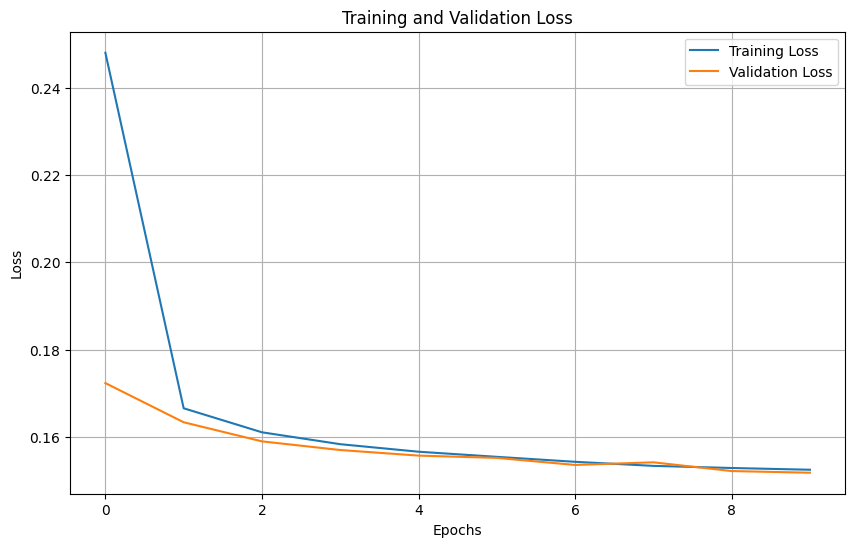

In [57]:
# Plot training and validation loss curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

94/94 - 1s - 6ms/step - loss: 0.1517
Test Loss: 0.15174496173858643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


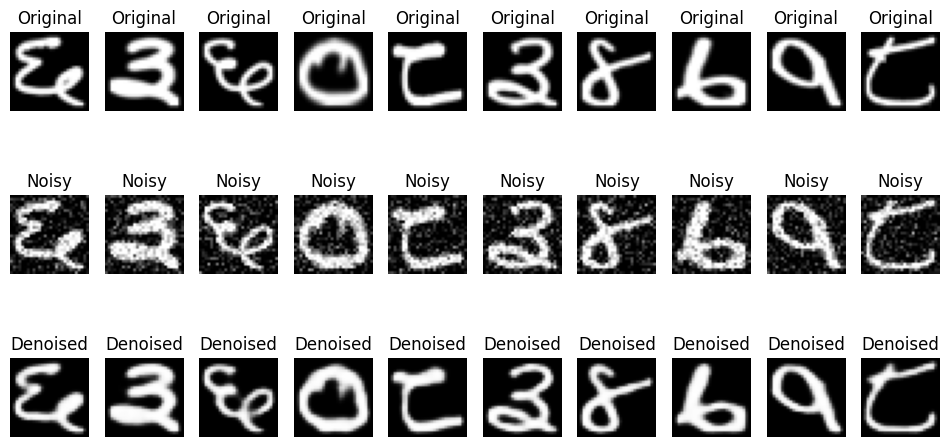

In [58]:
# Evaluate the model on the test set
test_loss = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print(f"Test Loss: {test_loss}")
n = 10
plt.figure(figsize=(12, 6))
for i in range(n):
    # Original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")
    # Noisy image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis("off")
    # Denoised prediction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    denoised = autoencoder.predict(np.expand_dims(x_test_noisy[i], axis=0))[0]
    plt.imshow(denoised.reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    plt.axis("off")
plt.show()

In [59]:
# Adding more layers or filters
def build_advanced_autoencoder():
    input_img = Input(shape=input_shape)
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Added filter
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    # Model
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder

In [60]:
x_train_noisy = add_gaussian_noise(x_train, noise_factor=0.5)  # Increasing noise factor
x_test_noisy = add_gaussian_noise(x_test, noise_factor=0.5)

In [61]:
history = autoencoder.fit(
    x_train_noisy, x_train,  # Noisy images as input, clean images as target
    epochs=20,  # Increasing epochs for more training
    batch_size=64,  # Smaller batch size for finer updates
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
)

Epoch 1/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2421 - val_loss: 0.1926
Epoch 2/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1898 - val_loss: 0.1871
Epoch 3/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1869 - val_loss: 0.1855
Epoch 4/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1853 - val_loss: 0.1839
Epoch 5/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1838 - val_loss: 0.1831
Epoch 6/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1830 - val_loss: 0.1819
Epoch 7/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1818 - val_loss: 0.1813
Epoch 8/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1816 - val_loss: 0.1807
Epoch 9/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1807 - val_loss: 0.1804
Epoch 10/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1802 - val_loss: 0.1798
Epoch 11/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1792 - val_loss: 0.1809
Epoch 12/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

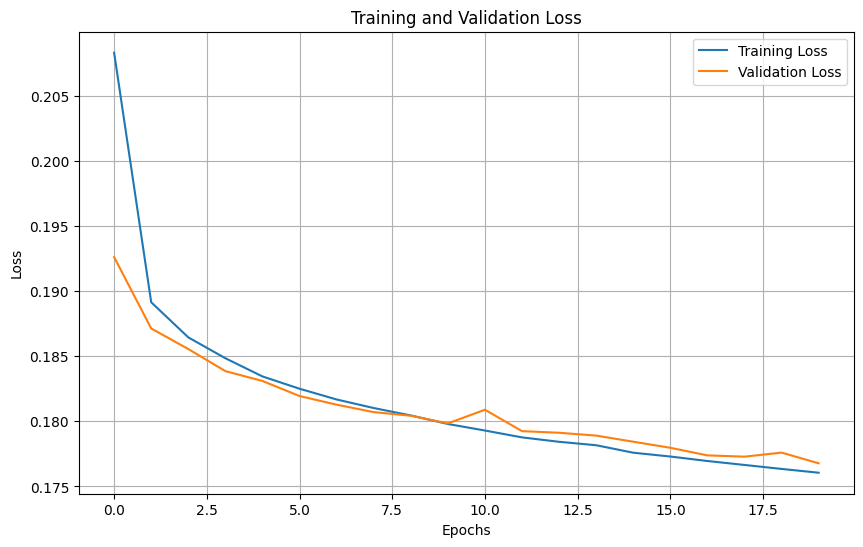

In [62]:
# Plot training and validation loss curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

94/94 - 0s - 2ms/step - loss: 0.1768
Test Loss: 0.1767759621143341
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


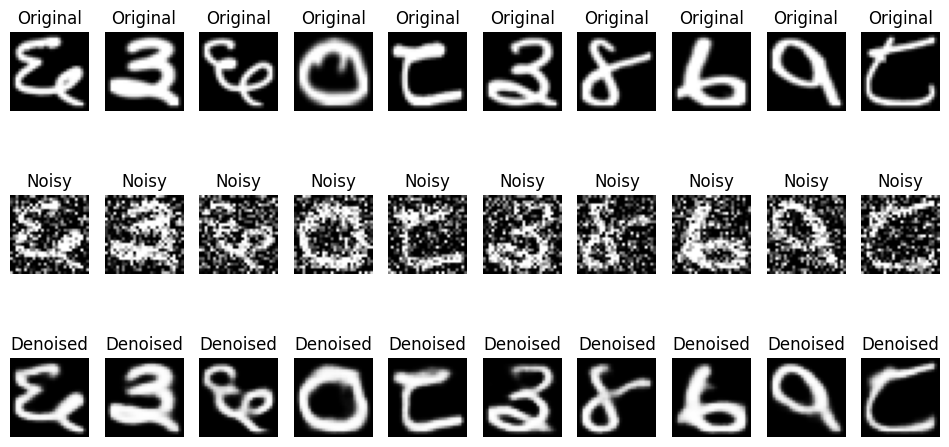

In [63]:
# Evaluate the model on the test set
test_loss = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print(f"Test Loss: {test_loss}")
n = 10
plt.figure(figsize=(12, 6))
for i in range(n):
    # Original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")
    # Noisy image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis("off")
    # Denoised prediction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    denoised = autoencoder.predict(np.expand_dims(x_test_noisy[i], axis=0))[0]
    plt.imshow(denoised.reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    plt.axis("off")
plt.show()